In [1]:
from pyctp import saftvrqmie
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

In [2]:
colors = ["k", "r", "b", "brown", "g", "purple"]

# Testing effect of refitted deuterium parameters

In [3]:
# Instanciate and init SAFT-VRQ Mie object (Aasen 2020: https://doi.org/10.1063/1.5136079)
qSAFT = saftvrqmie.saftvrqmie()
qSAFT.init("D2")
qSAFT.set_tmin(temp=2.0)
# Instanciate and init SAFT-VRQ Mie object with refitted parameters
qSAFT_MOD = saftvrqmie.saftvrqmie()
qSAFT_MOD.init("D2")
qSAFT_MOD.set_pure_fluid_param(1, 1.0, 3.00874e-10, 3.92388e+01, 7.0, 11.0)
qSAFT_MOD.redefine_critical_parameters()

In [4]:
p_scaling = 1.0e-6
rho_scaling = 1.0e-3
z = np.array([1.0])

In [5]:
def loadFile(filename, delimiter=None):
    file = open(filename, 'r')
    # Parse header
    nlines = 0
    for line in file:
        words = line.split()
        if words[0][0] == '#':
            nlines = nlines + 1
        else:
            break
    data = np.loadtxt(filename, skiprows=nlines, delimiter=delimiter)
    return data

## Load data generated using Richardson et al. 2014 (https://doi.org/10.1063/1.4864752)

In [6]:
data = loadFile("deuterium.csv",delimiter=",")
data_iso = loadFile("deuterium_isobars.csv",delimiter=",")
data_cp = loadFile("deuterium_ideal_cp.csv",delimiter=",")

## Plot phase envelope

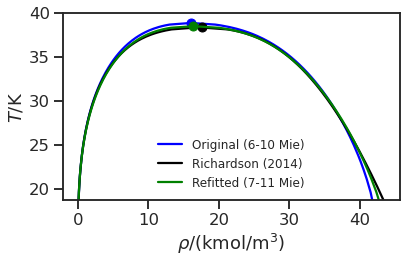

In [7]:
T_p, P_p, v_p = qSAFT.get_envelope_twophase(5.0e3, z, maximum_pressure=2.0e6, calc_v=True)
Tc_p, vc_p, Pc_p = qSAFT.critical(z)
plt.plot(rho_scaling/v_p, T_p, "b", label="Original (6-10 Mie)")
plt.plot([rho_scaling/vc_p], [Tc_p], "bo")
plt.plot(rho_scaling*data[:,2], data[:,0], "k", label="Richardson (2014)")
plt.plot(rho_scaling*data[:,3], data[:,0], "k")
plt.plot([rho_scaling*17.6*1e3], [38.34], color="k", marker="o")
T_fit, P_fit, v_fit = qSAFT_MOD.get_envelope_twophase(5.0e3, z, maximum_pressure=2.0e6, calc_v=True)
Tc_fit, vc_fit, Pc_fit = qSAFT_MOD.critical(z)
plt.plot(rho_scaling/v_fit, T_fit, "g", label="Refitted (7-11 Mie)")
plt.plot([rho_scaling/vc_fit], [Tc_fit], color="g", marker="o")
plt.xlabel(r"$\rho$/(kmol/m$^3$)")
plt.ylabel(r"$T$/K")
plt.ylim([18.724,40])
#plt.xlim([35,45])
leg = plt.legend(loc="best", frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("deuterium_T_rho.pdf")
plt.show()

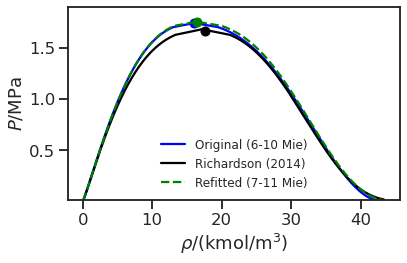

In [8]:
plt.plot(rho_scaling/v_p, p_scaling*P_p, "b", label="Original (6-10 Mie)")
plt.plot([rho_scaling/vc_p], [p_scaling*Pc_p], "bo")
plt.plot(rho_scaling*data[:,2], p_scaling*data[:,1], "k", label="Richardson (2014)")
plt.plot(rho_scaling*data[:,3], p_scaling*data[:,1], "k")
plt.plot([rho_scaling*17.6*1e3], [1e6*1.665*p_scaling], color="k", marker="o")
plt.plot(rho_scaling/v_fit, p_scaling*P_fit, "g", label="Refitted (7-11 Mie)", linestyle="--")
plt.plot([rho_scaling/vc_fit], [p_scaling*Pc_fit], color="g", marker="o")
plt.xlabel(r"$\rho$/(kmol/m$^3$)")
plt.ylabel(r"$P$/MPa")
plt.ylim([0.01,1.9])
#plt.xlim([35,45])
leg = plt.legend(loc="best", frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("deuterium_P_rho.pdf")
plt.show()

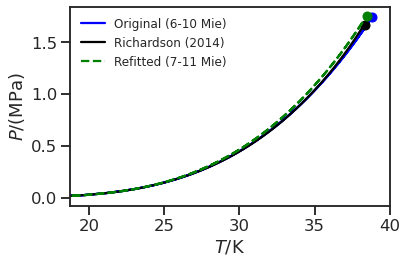

In [9]:
plt.plot(T_p, p_scaling*P_p, "b", label="Original (6-10 Mie)")
plt.plot([Tc_p], [p_scaling*Pc_p], "bo")
plt.plot(data[:,0], p_scaling*data[:,1], "k", label="Richardson (2014)")
plt.plot([38.34], [1e6*1.665*p_scaling], color="k", marker="o")
plt.plot(T_fit, p_scaling*P_fit, "g", label="Refitted (7-11 Mie)", linestyle="--")
plt.plot([Tc_fit], [p_scaling*Pc_fit], color="g", marker="o")
plt.ylabel(r"$P$/(MPa)")
plt.xlabel(r"$T$/K")
plt.xlim([18.724,40])
#plt.xlim([35,40])
leg = plt.legend(loc="best", frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("deuterium_TP.pdf")
plt.show()

## Isobars

In [10]:
Pa = np.array([2.0, 6.0, 15.0])*1e6
Ta = np.linspace(20.0, 110.0, 100)

In [11]:
def get_isobars(model):
    rho_p = []
    cp_p = []
    for p in Pa:
        rho = np.zeros_like(Ta)
        cp = np.zeros_like(Ta)
        for iT, T in enumerate(Ta):
            v, = model.specific_volume(T, p, z, qSAFT.LIQPH)
            rho[iT] = rho_scaling/v
            h, dhdt,  = model.enthalpy(T, p, z, qSAFT.LIQPH, dhdt=True, residual=True)
            cp[iT] = dhdt
        rho_p.append(rho)
        cp_p.append(cp)
    return rho_p, cp_p

In [12]:
rho_fit, cp_fit = get_isobars(qSAFT_MOD)
rho, cp = get_isobars(qSAFT)

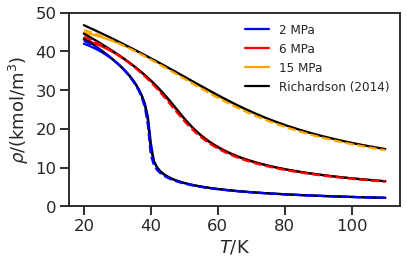

In [26]:
plt.plot(Ta, rho[0], "b", label="2 MPa")
plt.plot(Ta, rho[1], "r", label="6 MPa")
plt.plot(Ta, rho[2], "orange", label="15 MPa")

plt.plot(data_iso[:,0], rho_scaling*data_iso[:,4], "k", label="Richardson (2014)")
plt.plot(data_iso[:,0], rho_scaling*data_iso[:,5], "k")
plt.plot(data_iso[:,0], rho_scaling*data_iso[:,6], "k")

plt.plot(Ta, rho_fit[0], "b", linestyle="--")
plt.plot(Ta, rho_fit[1], "r", linestyle="--")
plt.plot(Ta, rho_fit[2], "orange", linestyle="--")


plt.ylabel(r"$\rho$/(kmol/m$^3$)")
plt.xlabel(r"$T$/K")
leg = plt.legend(loc="best", ncol=1, frameon=False, fontsize=12)
plt.ylim(0.0,50.0)
plt.tight_layout()
plt.savefig("deuterium_isobars.pdf")

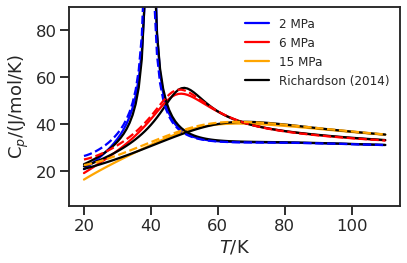

In [25]:
plt.plot(Ta, np.array(cp[0]) + data_cp[:,1], "b", label="2 MPa")
plt.plot(Ta, np.array(cp[1]) + data_cp[:,2], "r", label="6 MPa")
plt.plot(Ta, np.array(cp[2]) + data_cp[:,3], "orange", label="15 MPa")
plt.plot(data_iso[:,0], data_iso[:,1], "k", label="Richardson (2014)")
plt.plot(data_iso[:,0], data_iso[:,2], "k")
plt.plot(data_iso[:,0], data_iso[:,3], "k")
plt.plot(Ta, np.array(cp_fit[0]) + data_cp[:,1], "b", linestyle="--")
plt.plot(Ta, np.array(cp_fit[1]) + data_cp[:,2], "r", linestyle="--")
plt.plot(Ta, np.array(cp_fit[2]) + data_cp[:,3], "orange", linestyle="--")

plt.ylabel(r"C$_p$/(J/mol/K)")
plt.xlabel(r"$T$/K")
leg = plt.legend(loc="best", ncol=1, frameon=False, fontsize=12)
plt.ylim(5.0,90.0)
plt.tight_layout()
plt.savefig("deuterium_cp.pdf")